In [ ]:
#loading librariers
library(dplyr)
library(caret)
library(mlbench)
library(randomForest)
library(neuralnet)
library("scatterplot3d")
library("plot3D")
if(!require("nnet")){install.packages("nnet")}
library(rgl)
#library(InformationValue)
library(ISLR)
library(nnet)

fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}
fig(14,10)

set.seed(0)

In [3]:
#loading data sets
data(Ozone)
Ozone <- Ozone[complete.cases(Ozone),] %>% mutate(across(where(is.numeric), scale))

Ozone$V1 <- as.numeric(Ozone$V1)
Ozone$V2 <- as.numeric(Ozone$V2)
Ozone$V3 <- as.numeric(Ozone$V3)

#splitting data
train <-sample_frac(Ozone,300/333)

train_index <- as.numeric(rownames(train))

test <- Ozone[-train_index, ]

### Question 2 - Neural Network v. Random Forest

#### Question 2(a) - Tunning Random Forest
Based on the results of the random forest tuning, mtry = 2. This yielded an RMSE 0.2513 on the test set. Although it is outside the scope of this question, I also tested the perfomance of the bagged and base forest as controls. Interestlingly, the base random forest outperformed the tuned random forest with a test set RMSE of 0.2435, while the bagged tree outperformed both models with a test RMSE of 0.2433. This begs the question of why didn't cross validation select the bagged tree as the final model ?

##### Random Forest

,mtry
,<int>
2,2


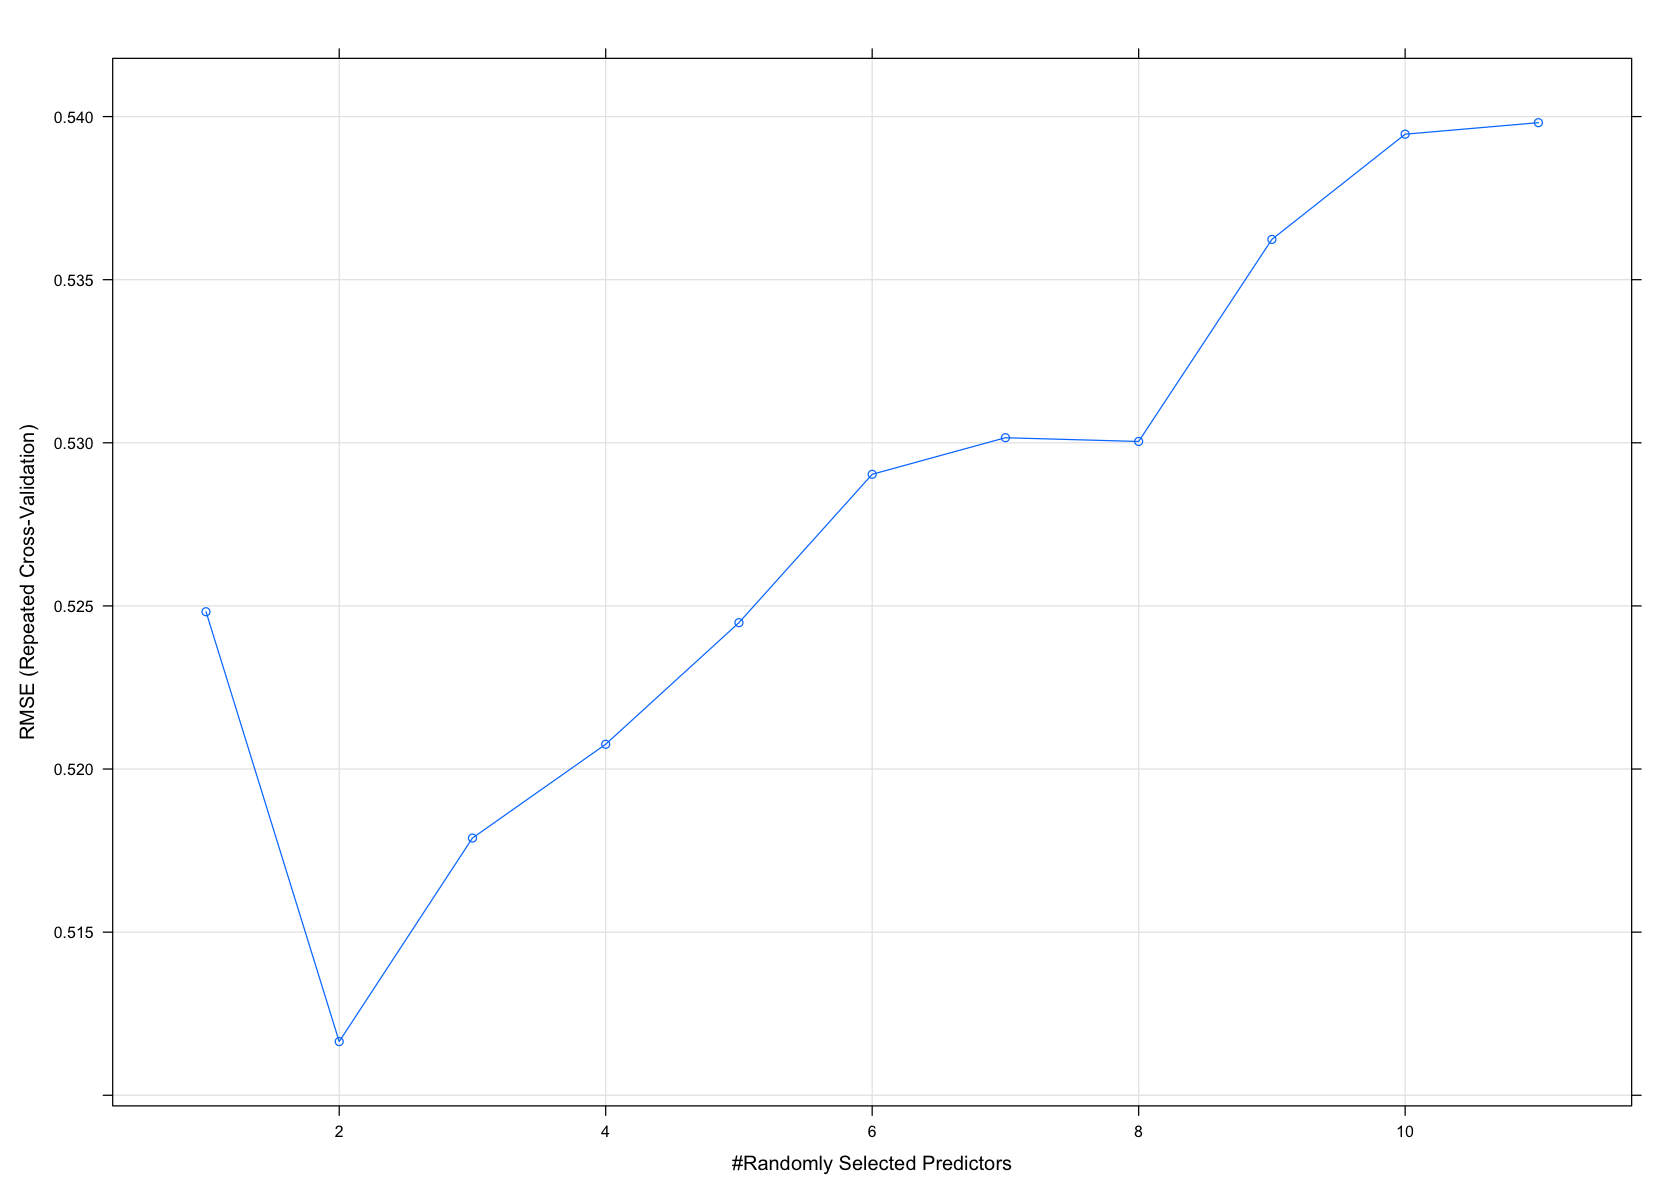

In [4]:
tr <- trainControl(method = "repeatedcv", number = 10, repeats = 3)
rf.tune.grid <- expand.grid(mtry = c(1:11))
rf.cv <- train(V4~., data = train, method = 'rf', tuneGrid = rf.tune.grid, trControl = tr)
plot(rf.cv)

#best tune
rf.cv$bestTune

In [5]:
#estimating MSE of untuned tree on test set
rf.base <- randomForest(V4~., data = train, importance = TRUE)
#estimating MSE of tuned tree on test set
rf.opt <- randomForest(V4~., data = train, importance = TRUE, mtry=11)
#estimating MSE of bagged tree on test set
rf.bagged <- randomForest(V4~., data = train, importance = TRUE, mtry=12)

#RMSE
RMSE(predict(rf.base,test),test$V4)
RMSE(predict(rf.opt,test),test$V4)
RMSE(predict(rf.bagged,test),test$V4)

[1] 0.2513001

[1] 0.2435935

[1] 0.2433061

#### Question 2(b) - Neural Net
I initially started using a grid of (1:5), (1:5), however, I found that I had to increase the max step size to 100000 to allow the model to take more iterations to converge at each configuratioallowInterruptst, once the first layer got to a 5 node configuration, I had make the step size very large (1000000). Consequently, to avoid a potential over-fit, I dropped the fifth layer and used a grid of (1:4),(0:4). I added zero to the second layer as well to test wether a second layer is even neccessary. Unfortunately, despite my increase in step size and reconfiguration of the nodes, I still encountered convergence issues and significant computational times. 
Due to these issues, I began increasing the threshold and saw massive decreases in computational time. I ultimately began by testing a grid (1:8) x (0:8) with a threshold of 0.3 and step size $1x10^6$. For this result, the (2,4) configuration perfomed the best. I increased the grid to (1:15)x(1:15), but had to significantly increase the threshold from 0.3 to 0.7 to keep cross validation time within a reasonable limit for the task. Again, I increased the grid size slightly to maximize the boost in computational time from the threshold increase. Overall, a configuration of (16,9) had the best perfomance RMSE of 0.1981. over 50 test RMSE samples.

In [6]:
nn.grid <- expand.grid(layer1=c(1:20),layer2=c(1:20),layer3=0) #since nnet can only handle one layer

In [ ]:
nn.cv <- train(V4~., 
            data=train, 
            method='neuralnet', 
            metric='RMSE', 
            tuneGrid=nn.grid, 
            trControl=tr,
            stepmax = 1e+06,
            threshold = 0.7
            )

,layer1,layer2,layer3
,<int>,<int>,<dbl>
309,16,9,0


,layer1,layer2,layer3,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD,MSE
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
309,16,9,0,0.5505711,0.7429717,0.426853,0.1091643,0.07693846,0.07671426,0.3031286


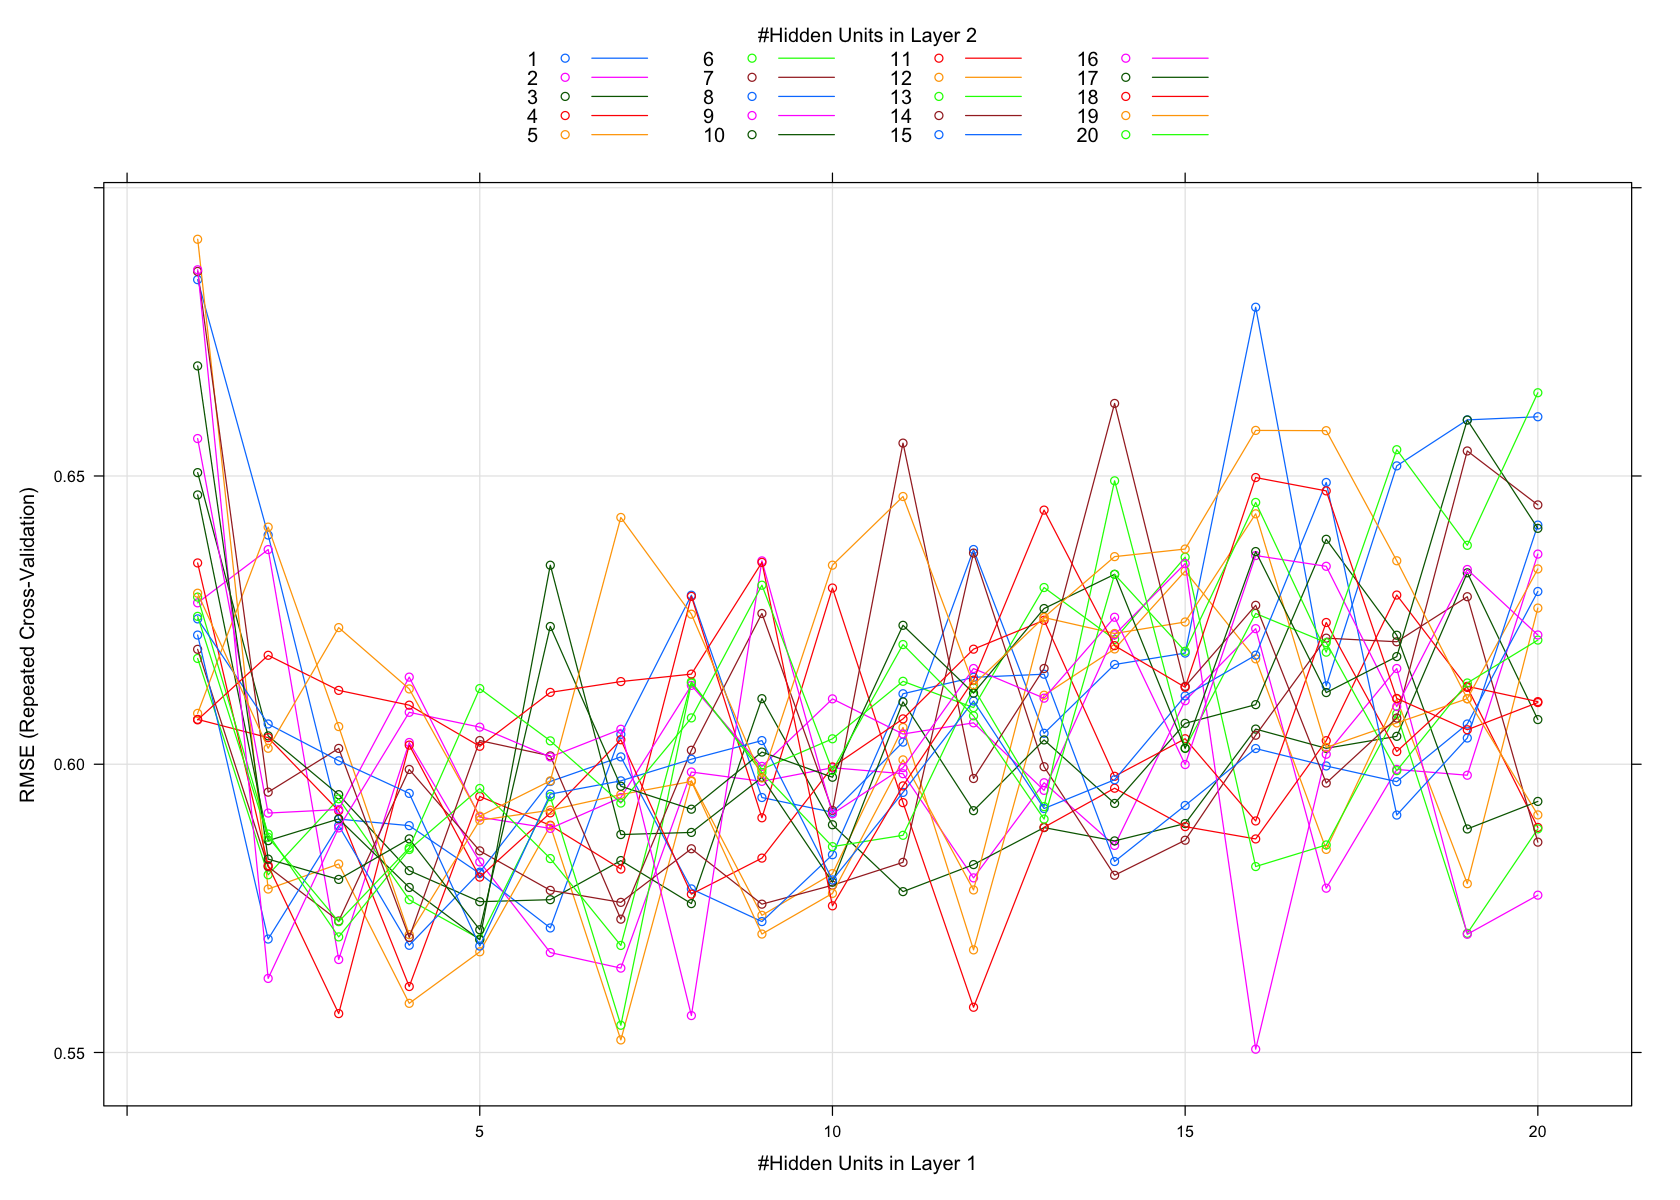

In [689]:
#best layer configuration in terms of RMSE 
# nn.cv$bestTune
#full details of configuration with errors
nn.bestconfig <- nn.cv$results[309,]
nn.bestconfig$MSE <- nn.cv$results[309,]$RMSE^2
# nn.bestconfig
#plot of results from cross validation
plot(nn.cv)

In [692]:
#the neural network performance metric have a large variances between two runs due 
#to the stochastic nature of the gradient descent.
#thus i record the error across 50 samples and choose the minimum
nn.rmse <- c()
for (i in 1:50){
    TEMP <- neuralnet(V4~.,
                data=train,
                hidden = c(16,9),
                stepmax = 1e+06,
                threshold = 0.7
                 )

    nn.rmse <- append(nn.rmse, RMSE(predict(TEMP,test),test$V4))

}

min(nn.rmse)

[1] 0.1980971

#### Question 2(c) - Discussion
I put a fraction of the effort I put into the neural network in tuning the random forest model. For the latter, the only paramter I needed to hypertune on was the number of predictors to use each iteration ($m_{try}$) and this process took one line of code and less than a second. The RMSE of this model was 0.2436. However, for the neural network, even though I was only hypertuning on layer1 and layer2, I had to adjust the stepmax and threshold parameters; increasing the work capacity of a neural network affects how many steps and how big of a step to take downhill. Too low a stepsize with a high network capacity results in the gradient not converging or significant increases computational time, while high step size might cause the descenent to step over the minimum and repeat this idefinitely. I used an intial node configuration set of (1:4)x(1:4) and had to increase the threshold by an order of magnitude ($1e+5 to 1e+6) and the stepsize due to the stepsize being too small for the amount of iterations set. After several iterations of adjusting the threshold and stepsize, I found a combination to optimze the speed that a sufficiently large grid of configurations, (1:20)x(1:20), could be tested. Subsequently, the RMSE of the resultant best network (a (16,9) configuration) was significantly lower than the in the tuned random forest model. I think in cases where there is much higher dimensional data and possibily more processing power, the neural network, when calibrated properly will outperform the random forest. However, in most cases and this case in particular, the random forest is ideal in terms of effort required, perfomance and even interpretability. 

### Question 3

In [104]:
#housekepping
data(PimaIndiansDiabetes2)
df <- PimaIndiansDiabetes2 |> select(-insulin, -triceps)
df <- df[complete.cases(df), ]
tr2 <- trainControl(method = "repeatedcv", number = 10, repeats = 3)

#splitting the data
train2 <-sample_frac(df,0.7)

train_index2 <- as.numeric(rownames(train2))

test2 <- df[-train_index2, ]

#### Question 3(a) - Logisitic Regression, Random Forest and Neural Networks
The best model for inference is the GLM Model. This model allows you to easily see how each parameter in the model is affecting the target response. However, the random forest also gives some perspective into which variables it considered strongest for spliiting the data while the neural net offers little inferential advantage. Though, the Random Forest offered the best predictive ability while the Neural Net, surprisingly outperformed the GLM.

##### Logistic Regression Model: 
The logisitic mode had an Accuracy of 0.8679 on the test set

In [198]:
#using cross validation to estimate test error
glm.cv <- train(diabetes ~ ., data = train2,
            method = "glm", family = "binomial",
            preProcess = c("center", "scale"), trControl = tr2)
summary(glm.cv)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8846  -0.7044  -0.4017   0.7558   2.1543  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.85453    0.11898  -7.182 6.86e-13 ***
pregnant     0.39175    0.13499   2.902 0.003707 ** 
glucose      1.01367    0.13039   7.774 7.61e-15 ***
pressure    -0.06648    0.12766  -0.521 0.602557    
mass         0.64905    0.13139   4.940 7.82e-07 ***
pedigree     0.41078    0.12416   3.308 0.000938 ***
age          0.17943    0.13945   1.287 0.198202    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 655.95  on 506  degrees of freedom
Residual deviance: 476.85  on 500  degrees of freedom
AIC: 490.85

Number of Fisher Scoring iterations: 5


In [199]:
#logistic model
glm.fin <- glm(diabetes ~ ., data=train2, family = "binomial")

#predicted values conversion to 1 and 0
glm.pred <- as.factor(
    ifelse(
        predict(glm.fin, test2, type="response") > 0.5, 1, 0)
)
#observed response conversion to 1 and 0
diabetes.actuals <- as.factor(
    ifelse(test2$diabetes=="pos", 1, 0)
)

#create confusion matrix
confusionMatrix(diabetes.actuals, glm.pred)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 155  17
         1  33  46
                                         
               Accuracy : 0.8008         
                 95% CI : (0.746, 0.8484)
    No Information Rate : 0.749          
    P-Value [Acc > NIR] : 0.03206        
                                         
                  Kappa : 0.5114         
                                         
 Mcnemar's Test P-Value : 0.03389        
                                         
            Sensitivity : 0.8245         
            Specificity : 0.7302         
         Pos Pred Value : 0.9012         
         Neg Pred Value : 0.5823         
             Prevalence : 0.7490         
         Detection Rate : 0.6175         
   Detection Prevalence : 0.6853         
      Balanced Accuracy : 0.7773         
                                         
       'Positive' Class : 0              
                                         

##### Random Forest Model: 
The tuning revealed ideal amount of predictors for the lowest OOB Error was 2. Consequently, the tuned randomforest had an Accuracy of 0.9323  on the test set. However, the control outperformed the tuned model with a performance of 0.9402 on the test. Ultimately, the tuning was did not produce the best performing model, however, for the scope of the question, the tuned model will be used moving forward.  

,mtry
,<int>
1,1


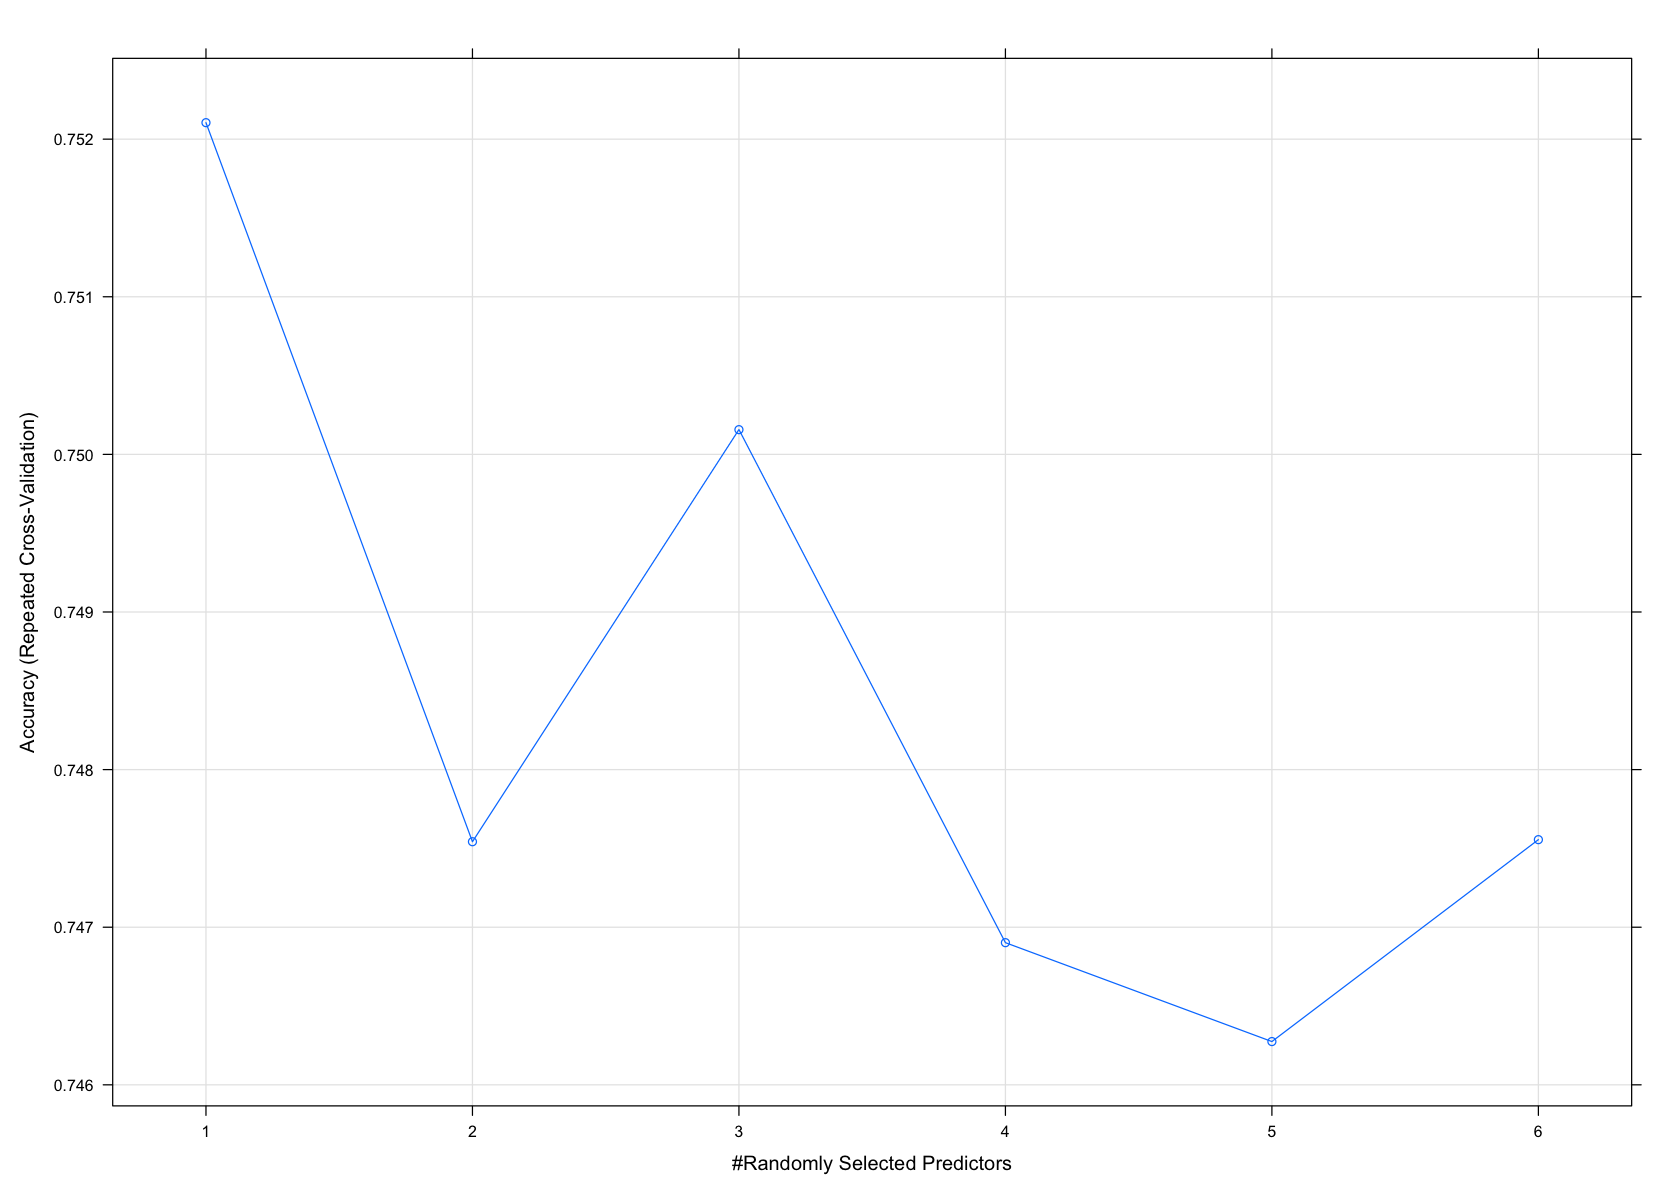

In [114]:
#tuning random forest for optimal number of predictors
tr2 <- trainControl(method = "repeatedcv", number = 10, repeats = 3)
rf.tune.grid2 <- expand.grid(mtry = c(1:6))
rf.cv2 <- train(diabetes~., data = train2, method = 'rf', tuneGrid = rf.tune.grid2, trControl = tr2)
plot(rf.cv2)

#best tune
rf.cv2$bestTune

In [115]:
#training base and tuned models
rf.base <- randomForest(diabetes~., data = train2, importance = TRUE)
rf.tuned <- randomForest(diabetes~., data = train2, importance = TRUE, mtry = 1)

In [116]:
#predictions for both models
tuned.pred <- as.factor(
    ifelse(
        predict(rf.tuned,test2, type = "response") == "pos", 1, 0)
)

base.pred <- as.factor(
    ifelse(
        predict(rf.base,test2, type = "response") == "pos", 1, 0)
    )

In [117]:
#calculating accuracy for both models
confusionMatrix(diabetes.actuals,base.pred)
confusionMatrix(diabetes.actuals,tuned.pred)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 166   6
         1   9  70
                                          
               Accuracy : 0.9402          
                 95% CI : (0.9033, 0.9662)
    No Information Rate : 0.6972          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.86            
                                          
 Mcnemar's Test P-Value : 0.6056          
                                          
            Sensitivity : 0.9486          
            Specificity : 0.9211          
         Pos Pred Value : 0.9651          
         Neg Pred Value : 0.8861          
             Prevalence : 0.6972          
         Detection Rate : 0.6614          
   Detection Prevalence : 0.6853          
      Balanced Accuracy : 0.9348          
                                          
       'Positive' Class : 0               
                              

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 166   6
         1  11  68
                                          
               Accuracy : 0.9323          
                 95% CI : (0.8938, 0.9601)
    No Information Rate : 0.7052          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8403          
                                          
 Mcnemar's Test P-Value : 0.332           
                                          
            Sensitivity : 0.9379          
            Specificity : 0.9189          
         Pos Pred Value : 0.9651          
         Neg Pred Value : 0.8608          
             Prevalence : 0.7052          
         Detection Rate : 0.6614          
   Detection Prevalence : 0.6853          
      Balanced Accuracy : 0.9284          
                                          
       'Positive' Class : 0               
                              

##### Neural Network Model:
After tuning and an expansive search, the optimal number of hidden layers was 37 layers and had an average accuray of 0.8446 on the test set. I took the best performance over 50 iterations. 

In [25]:
#setting up search grid
nn.grid2 <- expand.grid(size=c(1:45),decay=0)

In [26]:
#training neural network
nn2.cv <- train(diabetes~., 
            data=train2, 
            method='nnet', 
            metric='Accuracy', 
            tuneGrid=nn.grid2, 
            trControl=tr,
            stepmax = 1e+06,
            threshold = 0.7,
            trace = FALSE
            )

,size,decay
,<int>,<dbl>
37,37,0


,size,decay,Accuracy,Kappa,AccuracySD,KappaSD
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
37,37,0,0.7269333,0.3852326,0.06176757,0.1358079


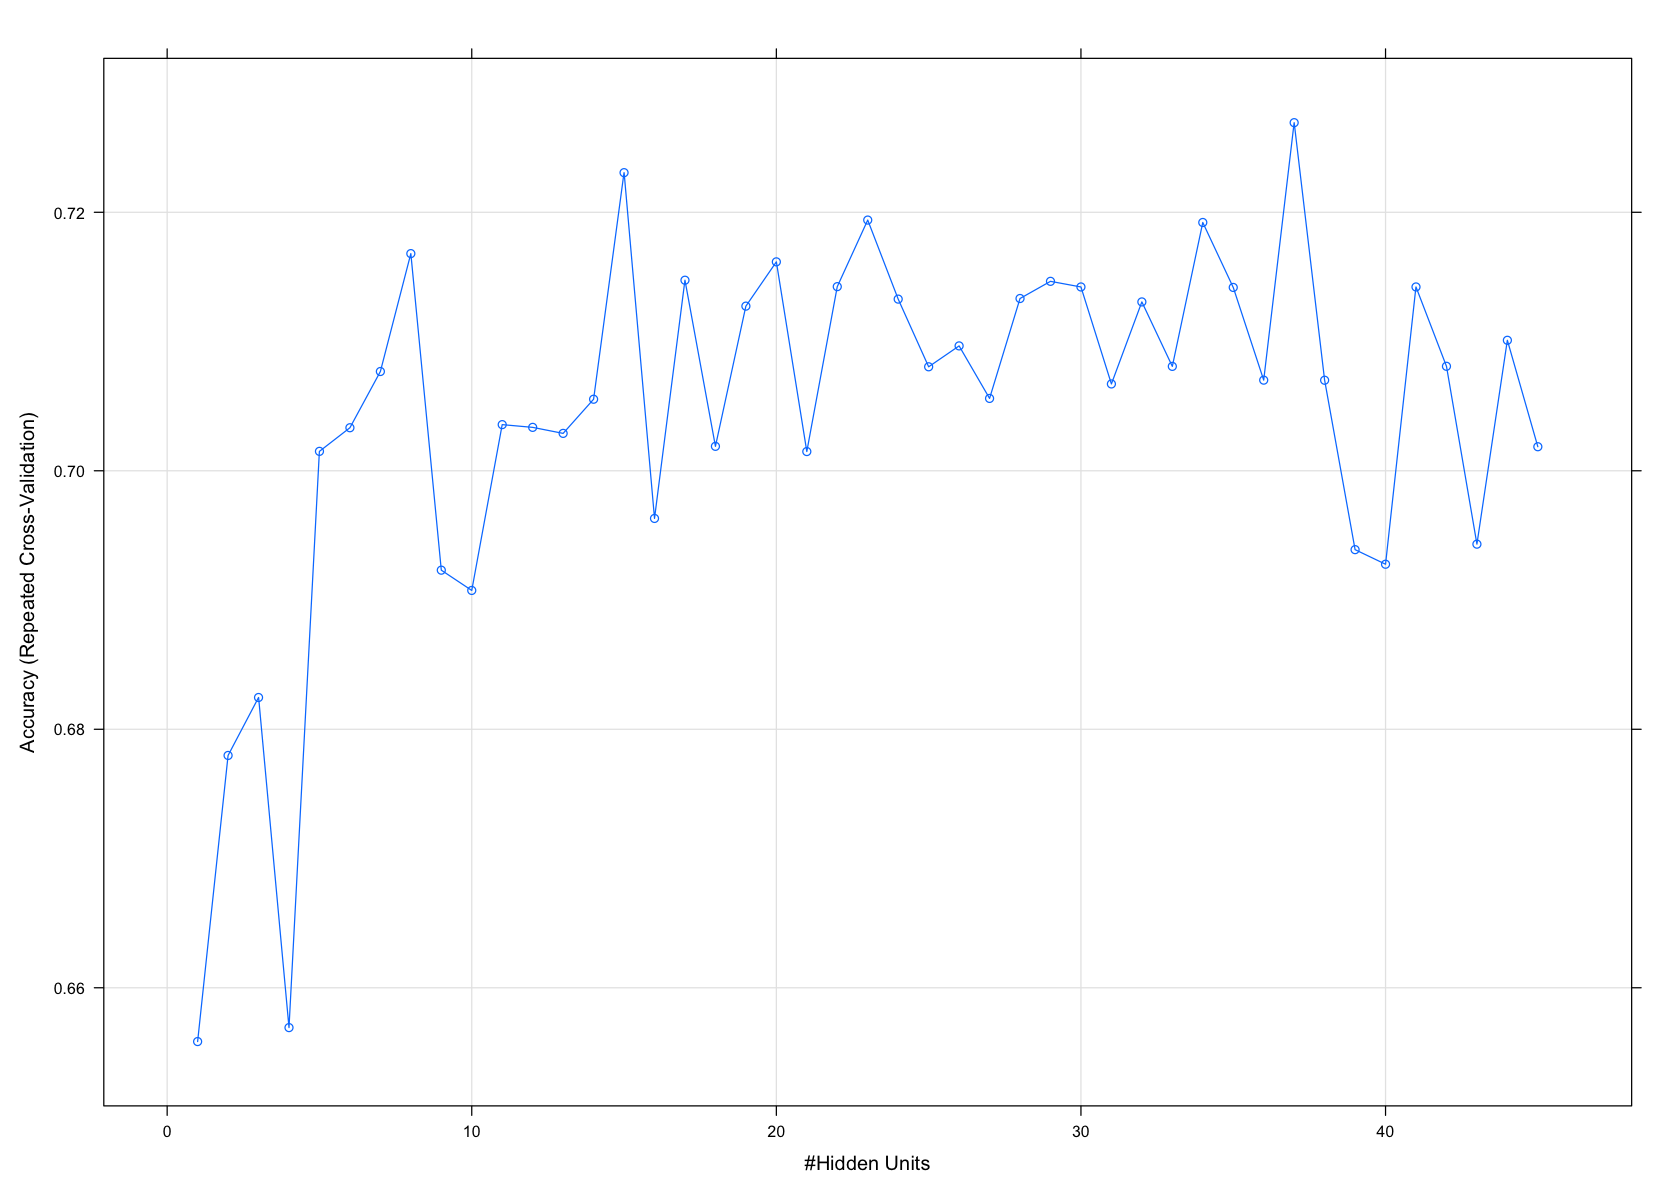

In [29]:
#best layer configuration in terms of RMSE 
nn2.cv$bestTune
#full details of configuration with errors
nn2.cv$results[37,]
#plot of results from cross validation
plot(nn2.cv)

In [ ]:
nn.fin <- nnet(diabetes~.,
                data=train2,
                size = 37,
                stepmax = 1e+06,
                threshold = 0.1,
                # trace = FALSE 
              )

In [275]:
#the neural network performance metric have a large variances between two runs.
#thus i average the accuracy across 50 samples.
avg.acc <- c()
for (i in 1:50){
    opt.nn2 <- nnet(diabetes~.,
                data=train2,
                size = 37,
                stepmax = 1e+06,
                threshold = 0.7,
                trace = FALSE )
    
    nn2.pred <- as.factor(ifelse(predict(opt.nn2,test2) > 0.5, 1, 0))

    avg.acc <- append(avg.acc, confusionMatrix(nn2.pred, diabetes.actuals)$overall['Accuracy'])

}

max(avg.acc)

[1] 0.8446215

#### 3(b)

In [252]:
# seq(from = min(test2$glucose), to = max(test2$glucose), length.out = 100) [will revisit for further investigation]
gluc.data <- data.frame(glucose = sample(min(test2$glucose):max(test2$glucose), 100, replace = "TRUE"),
                        pregnant = mean(test2$pregnant),
                        pressure = mean(test2$pressure),
                        mass = mean(test2$mass),
                        pedigree = mean(test2$pedigree),
                        age = mean(test2$age)
                        )


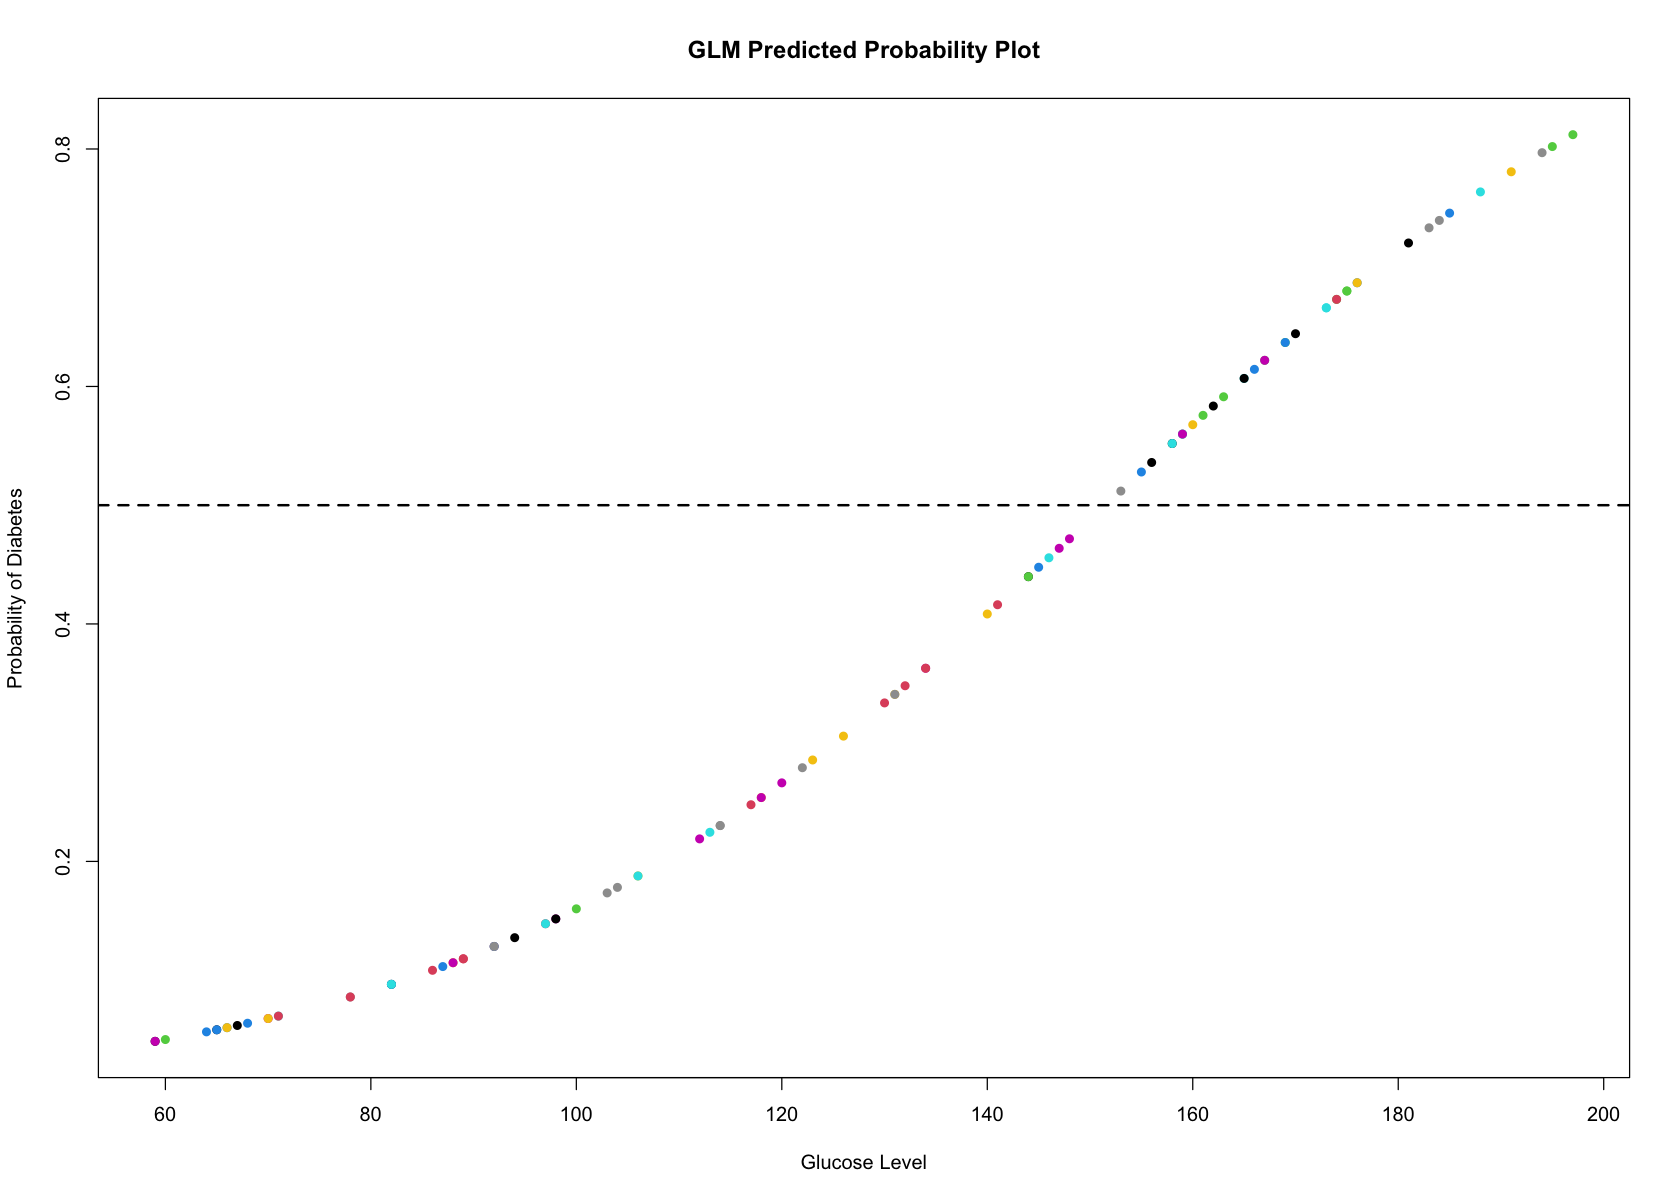

In [294]:
#logistic model
model1 <- predict(glm.fin, gluc.data, type = "response")
plot(gluc.data$glucose, model1,
    ylab = "Probability of Diabetes",
    xlab = "Glucose Level",
    main = "GLM Predicted Probability Plot",
    pch=16, col = 1:100)
abline(h=0.5, lty = 2, lwd = 2)

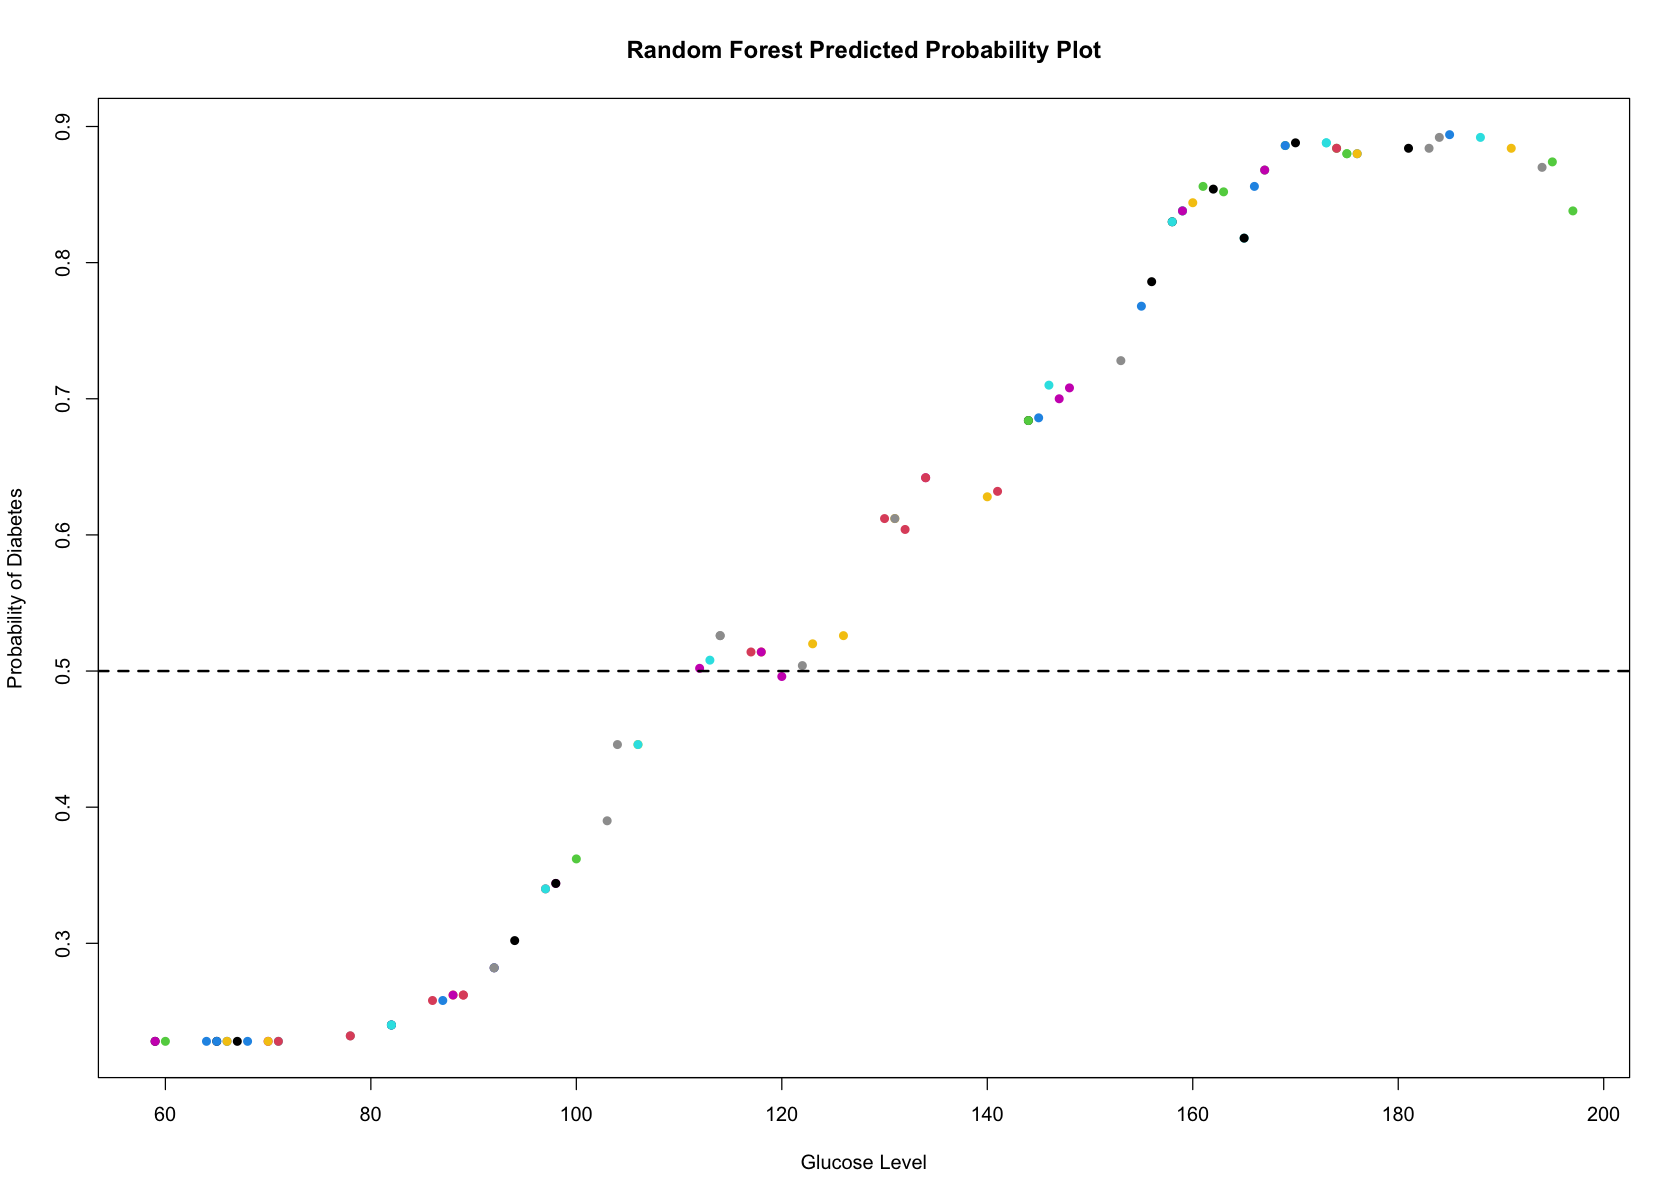

In [295]:
#random forest
model2 <- predict(rf.tuned, gluc.data, type = "prob")[,2] #this produces two columns with pred for each class
plot(gluc.data$glucose, model2,
    ylab = "Probability of Diabetes",
    xlab = "Glucose Level",
    main = "Random Forest Predicted Probability Plot",
    pch = 16, col = 1:100)
abline(h=0.5, lty = 2, lwd = 2)

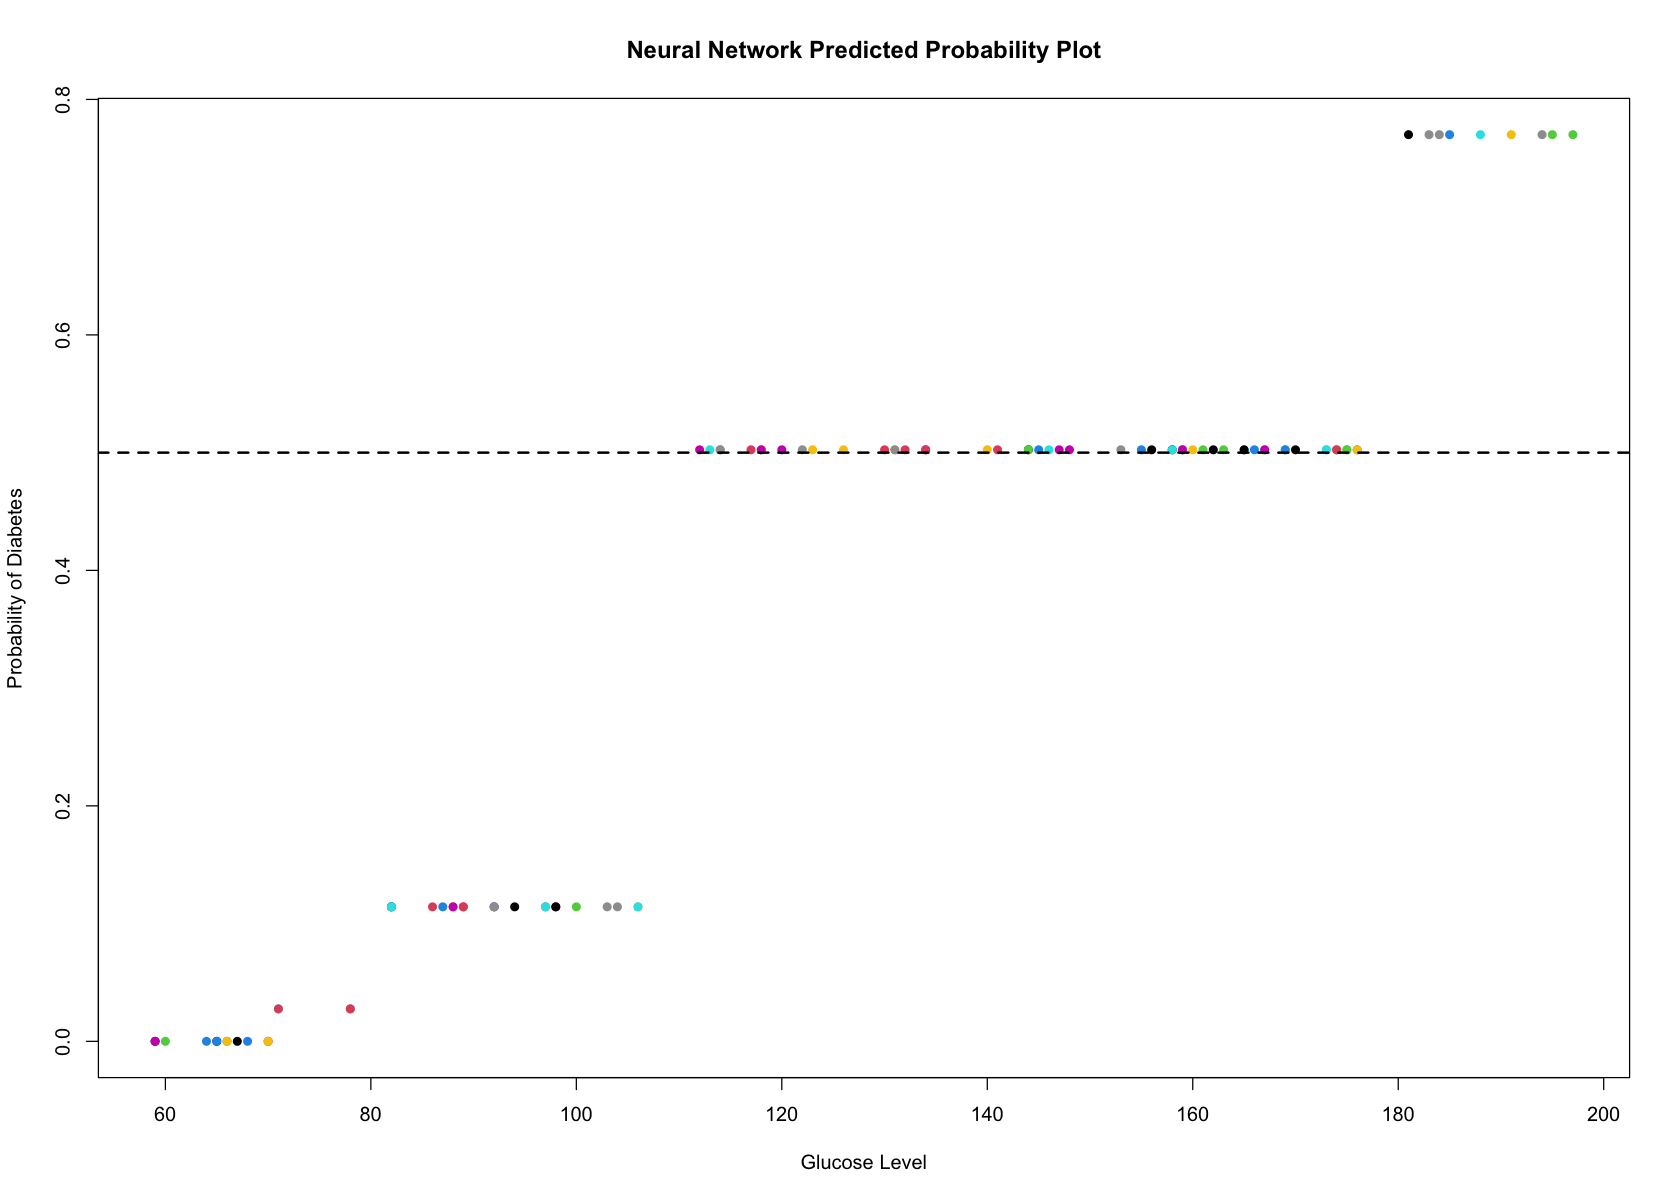

In [756]:
#neural net [interesting, everytime I run the nnet function, I get a completely different set of probabilities and vastly different graph shapes. Investigate later]
nn.fin <- nnet(diabetes~.,  #I got tired of running the nn in a seperate block. This isn't standard coding practice
        data=train2,
        size = 37,
        stepmax = 1e+06,
        threshold = 0.1,
        trace = FALSE 
        )
model3 <- predict(nn.fin,newdata = gluc.data )

plot(gluc.data$glucose, model3,
    ylab = "Probability of Diabetes",
    xlab = "Glucose Level",
    main = "Neural Network Predicted Probability Plot",
    col = 1:100, pch =16)
abline(h=0.5, lty = 2, lwd = 2)

#### Question 3(c)

##### I would say that based on the shape of the curve from each graph, you can understand how changes in glucose affect changes in the prediction. For instance, looking at the Logistic Model and Neural Net Curves, that a little change in glucose level when the glucose level is small results in a small change in the chance that someone has diabetes. However, for glucose values near the middle of the graph, have a greater impact on how the probability of having diabetes. Moreover, persons with glucose level near the median will have a higher chance of being misdiagnosed.Though, in the Random Forest curve, the relationship appears to be more extreme. In the latter models, they push inputs towards 0 or 1, while the Random Forest model seems to shove them there. Relative changes glucose and diabetes near the median have even more of an impact. Utlimately, the GLM and NN are the least sensitive to changes in glucose level near its median than the Random Forest.